In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('C:\\Users\\thesk\\eclipse-workspace\\riga.csv')

In [3]:
df.head(3)

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,lat,lon,price
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3,5,LT proj.,Brick-Panel,All amenities,56.955484,24.202139,250
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7,9,602,Panel,All amenities,56.899798,24.098350,300
2,For sale,centrs,Ieroču 6,2,33.0,1,2,P. kara,Wood,Partial amenities,56.975092,24.139884,13500


In [4]:
# List of numerical features: 
df1 = df.select_dtypes(include=[np.number])
num_features = list(df1)
print(num_features)

['rooms', 'area', 'floor', 'total_floors', 'lat', 'lon', 'price']


In [5]:
# remove the target variable
num_features.pop()
print(num_features)

['rooms', 'area', 'floor', 'total_floors', 'lat', 'lon']


In [6]:
# List of categorical features: 
df2 = df.select_dtypes(include=['object'])
cat_features = list(df2)
print(cat_features)

['op_type', 'district', 'street', 'house_seria', 'house_type', 'condition']


In [7]:
# ColumnTransformer cannot do multiple transforms on a single column, always takes the original df as input
# Use Pipeline for multiple steps on a single column as Pipeline takes previous step's output as next step's input
# ColumnTransformer has a three-element tuple: the name of the transformer, the transform to apply, and the column indices

num_pipe = Pipeline(steps=[('i',SimpleImputer(missing_values=np.nan, strategy="median")),
                            ('s', MinMaxScaler())])

cat_pipe = Pipeline(steps=[('i',SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                            ('oe',OrdinalEncoder()),
                            ('sc', MinMaxScaler())])

ct = ColumnTransformer(transformers=[('num',num_pipe,num_features),
                                    ('cat',cat_pipe,cat_features)],remainder="passthrough")  #the default value is ‘drop’ which drops the other columns and returns only the transformed ones, but we want the entire df, it is not neccesary to transform the target variable

df = ct.fit_transform(df)

In [8]:
# ColumnTransformer returned an array, putting it back into a dataframe
df = pd.DataFrame(df, columns = ['op_type', 'district', 'street', 'rooms', 'area', 'floor', 'total_floors', 'house_seria', 'house_type', 'condition', 'lat', 'lon','price'])

In [9]:
df.head(3)

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,lat,lon,price
0,0.000000,0.045346,0.086957,0.137931,0.333753,0.625656,0.0,0.553191,0.202008,0.500000,0.2,0.0,250.0
1,0.066667,0.100239,0.260870,0.275862,0.139539,0.345587,0.0,0.829787,0.608835,0.285714,0.6,0.0,300.0
2,0.066667,0.059666,0.000000,0.034483,0.402139,0.457664,1.0,0.872340,0.299197,0.642857,1.0,0.5,13500.0


In [10]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

<AxesSubplot:>

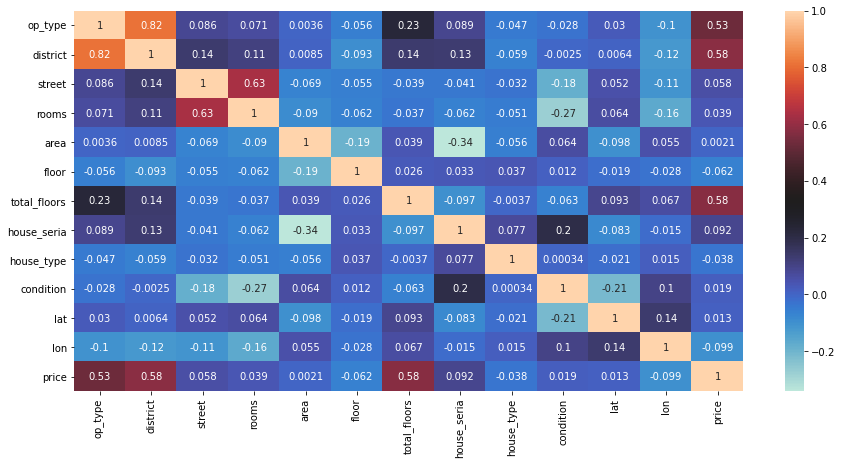

In [12]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,cmap='icefire')

The real estate type (For sale, For rent) and District correlate most with price.

In [13]:
# Ridge Regression for many large parameters of about the same value, i.e. when most predictors truly impact the response
r = Ridge()                                  # default alpha=1, full penalty
r.fit(X_train,y_train)
y_pred = r.predict(X_test)
print(r2_score(y_test,y_pred))

0.6130826763772838


In [14]:
# Define evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [15]:
# GridSearch
param = {'alpha':[0.001, 0.01, 0.01, 1, 10],
    'fit_intercept':[True,False],
    'normalize':[True,False]}

In [16]:
r = Ridge()
gs = GridSearchCV(r, param, scoring='r2', cv = cv, n_jobs=-1)
grid = gs.fit(df, y)                                                        # fitting the model for grid search 
print('Best Score: {}'.format(grid.best_score_))
print('Best Hyperparameters: {}'.format(grid.best_params_))

Best Score: 1.0
Best Hyperparameters: {'alpha': 0.001, 'fit_intercept': True, 'normalize': False}


In [17]:
r = Ridge(alpha=0.001, fit_intercept=True, normalize = False, solver ='auto')   # the dataframe was already normalized
rr = r.fit(X_train,y_train)
y_pred = rr.predict(X_test)
print(r2_score(y_test,y_pred))

0.6128796163738753


In [18]:
mae = np.mean(np.abs(y_test - y_pred))
coefs = dict(zip(['Intercept'] + df.columns.tolist()[:-1],
np.round(np.concatenate((rr.intercept_, rr.coef_),
axis=None), 3)))

print('Ridge Regression MAE: {}'.format(np.round(mae, 2)))
print('Ridge Regression coefficients:')
coefs

Ridge Regression MAE: 30917.04
Ridge Regression coefficients:


{'Intercept': -61514.936,
 'op_type': 4101.892,
 'district': 447034.104,
 'street': 9353.943,
 'rooms': -4871.09,
 'area': -3125.449,
 'floor': -16262.574,
 'total_floors': 83739.085,
 'house_seria': 19685.949,
 'house_type': -2341.294,
 'condition': 14441.208,
 'lat': -4914.86,
 'lon': -50937.626}